*by Ismael Pérez Roldán*
# PFG - Painting Movement Classifier
Este notebook contiene el script encargado de clasificar los movimientos artísticos a través de Deep Learning.   

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
import pydot
import cv2
import random
from collections import Counter
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils import shuffle

#Keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Embedding, LSTM
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.models import load_model

import itertools


Using TensorFlow backend.


## Config Dataset

In [2]:
train_route = os.path.join(os.getcwd(), 'dataset', 'train');
validate_route = os.path.join(os.getcwd(), 'dataset', 'validate');
model_route = os.path.join(os.getcwd(), 'models', '');

movements = ['cubism', 'impressionism', 'symbolism',
             'postpainterly_abstraction', 'postimpressionism']

num_classes = len(movements)

## Function declaration

## Slice Function

In [3]:
def slice_img(spec, size):
    num_slices = int(spec.shape[1] / size)
    slices = []  
    
    for i in range(0, num_slices):
        slices.append(spec[size*i : size*(i+1):, size*i : size*(i+1)])
    return slices

### Load Data function

In [4]:
def load_data(route, samples_per_class, mode='train', balanced=False):
    data = []
    slices = []
    X = []
    Y = []
    Z = []
        
    for m in movements:
        files = os.listdir(os.path.join(route, m))
        category = movements.index(m)
        
        pbar = tqdm(range(samples_per_class))
        pbar.set_description("Processing %s" % m)
        for i in pbar:
            try:
                img = cv2.imread(os.path.join(route, m, files[i]))
                slices = slice_img(img, slice_size)
                for s in slices:
                    data.append([s, category])
                if mode == 'test':
                    Z.append([len(slices), category])
            except Exception as e:
                pass
                                    
    if mode == 'train':
        random.shuffle(data)
        
    for features, label in data:
        X.append(features)
        Y.append(label)

    # Free up memory
    del(data)
    del(img)
    del(slices)
    
    X = np.array(X)
    Y = np.array(Y)
    
    if balanced:
        counter = Counter(Y)
        min_samples = counter.most_common()[-1][1]
        total_per_genre = [i[1] for i in sorted(counter.most_common())]
        to_delete = [m - min_samples for m in total_per_genre]

        for g in range(len(movements)):
            indices = np.where(Y == g)[0][:to_delete[g]]
            X = np.delete(X, indices, axis=0)
            Y = np.delete(Y, indices, axis=0)

    X = X.reshape(-1, slice_size, IMG_SIZE, 3)
    Y = to_categorical(Y, num_classes=num_classes)    
    print(len(X))
    print(len(Y))
    return X, Y, Z

### Plot Distribution function

In [5]:
def plot_distribution(x): 
    x = [np.argmax(x[i]) for i in range(len(x))]
    y = [i for i in range(len(movements)+1)]
    
    n = plt.hist(x, bins=y, alpha=0.8, histtype='bar', ec='black', align='left')
    plt.ylabel('Samples')
    plt.xticks(y, movements)
    plt.grid(axis='y', linestyle='-')

    plt.show()
    
    return n

## Loading Datasets

In [6]:
training_samples = 450 # 450 max, else the computer will shutdown
test_samples = 50
IMG_SIZE = 264
slice_size = 127
balanced = True

X_train = []
Y_train = []
X_test = []
Y_test = []

In [7]:
print('Loading Training Data...')
X_train, Y_train, Z_train = load_data(train_route, training_samples, mode='train', balanced=balanced)
print(len(X_train))

Loading Training Data...



1885
1885
1885


### Train

In [9]:
def reshape_data(X):
    X = X.reshape(-1, X.shape[1], X.shape[2], 3)
    return X
        

def build_model(loss, optimizer, metrics, input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
        
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
        
    model.add(Conv2D(264, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Conv2D(264, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
        
    model.add(Dense(3060))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
        
        
    model.add(Dense(len(movements)))
    model.add(Activation('softmax'))
        
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)        
    return model

def train_model(model, epochs):
    model.summary()

    mcp_save = ModelCheckpoint(os.path.join(model_route, 'model3.h5'), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, 
              callbacks=[mcp_save, reduce_lr_loss]) 

    plot_model(model, to_file=model_route + 'model3.png')
    
    model.save(os.path.join(model_route, 'final_model.h5'))
    return history

In [10]:
#import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
#config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
#sess = tf.Session(config=config)
#set_session(sess)

model_type = 'CNN'

loss = 'categorical_crossentropy'
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = sgd
metrics = ['accuracy']

batch_size = 32
epochs = 100

X_train = reshape_data(X_train)
input_shape = X_train.shape[1:]

model = build_model(loss, optimizer, metrics, input_shape, typ=model_type)
history = train_model(model, epochs, typ=model_type)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 262, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 125, 262, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 131, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 129, 64)       18496     
_________________________________________________________________
activation_2 (Activation)    (None, 60, 129, 64)       0         
_________________________________________________________________
max_pooling2d_2 (MaxP

C:\Users\ilezad\Anaconda3\envs\tf_gpu\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Instructions for updating:
Use tf.cast instead.
Train on 1508 samples, validate on 377 samples
Epoch 1/100
1508/1508 [==============================] - ETA: 6:04 - loss: 7.2829 - acc: 0.156 - ETA: 3:01 - loss: 8.1218 - acc: 0.140 - ETA: 2:00 - loss: 7.4003 - acc: 0.166 - ETA: 1:29 - loss: 6.1229 - acc: 0.187 - ETA: 1:11 - loss: 5.2647 - acc: 0.200 - ETA: 58s - loss: 4.7779 - acc: 0.187 - ETA: 49s - loss: 4.3584 - acc: 0.18 - ETA: 43s - loss: 4.0235 - acc: 0.18 - ETA: 38s - loss: 3.7632 - acc: 0.18 - ETA: 33s - loss: 3.5507 - acc: 0.19 - ETA: 30s - loss: 3.3786 - acc: 0.18 - ETA: 27s - loss: 3.2419 - acc: 0.18 - ETA: 25s - loss: 3.1189 - acc: 0.18 - ETA: 22s - loss: 3.0077 - acc: 0.19 - ETA: 20s - loss: 2.9130 - acc: 0.19 - ETA: 19s - loss: 2.8339 - acc: 0.19 - ETA: 17s - loss: 2.7615 - acc: 0.19 - ETA: 16s - loss: 2.6982 - acc: 0.20 - ETA: 15s - loss: 2.6395 - acc: 0.20 - ETA: 14s - loss: 2.5891 - acc: 0.20 - ETA: 13s - loss: 2.5401 - acc: 0.20 - ETA: 12s - loss: 2.4947 - acc: 0.20 - E

1508/1508 [==============================] - ETA: 5s - loss: 1.4934 - acc: 0.250 - ETA: 5s - loss: 1.4414 - acc: 0.328 - ETA: 5s - loss: 1.4815 - acc: 0.312 - ETA: 5s - loss: 1.4977 - acc: 0.328 - ETA: 5s - loss: 1.5142 - acc: 0.306 - ETA: 5s - loss: 1.5280 - acc: 0.317 - ETA: 5s - loss: 1.5430 - acc: 0.303 - ETA: 5s - loss: 1.5321 - acc: 0.312 - ETA: 5s - loss: 1.5072 - acc: 0.329 - ETA: 4s - loss: 1.5076 - acc: 0.331 - ETA: 4s - loss: 1.5177 - acc: 0.321 - ETA: 4s - loss: 1.5115 - acc: 0.325 - ETA: 4s - loss: 1.4968 - acc: 0.329 - ETA: 4s - loss: 1.4876 - acc: 0.334 - ETA: 4s - loss: 1.4870 - acc: 0.337 - ETA: 4s - loss: 1.4901 - acc: 0.337 - ETA: 4s - loss: 1.4924 - acc: 0.336 - ETA: 3s - loss: 1.5006 - acc: 0.331 - ETA: 3s - loss: 1.5008 - acc: 0.330 - ETA: 3s - loss: 1.5000 - acc: 0.328 - ETA: 3s - loss: 1.5032 - acc: 0.327 - ETA: 3s - loss: 1.5042 - acc: 0.323 - ETA: 3s - loss: 1.5086 - acc: 0.322 - ETA: 3s - loss: 1.5093 - acc: 0.321 - ETA: 2s - loss: 1.5094 - acc: 0.320 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 1.5304 - acc: 0.312 - ETA: 6s - loss: 1.4257 - acc: 0.328 - ETA: 5s - loss: 1.3727 - acc: 0.364 - ETA: 5s - loss: 1.3711 - acc: 0.367 - ETA: 5s - loss: 1.3452 - acc: 0.381 - ETA: 5s - loss: 1.3527 - acc: 0.364 - ETA: 5s - loss: 1.3229 - acc: 0.375 - ETA: 5s - loss: 1.3491 - acc: 0.382 - ETA: 5s - loss: 1.3499 - acc: 0.392 - ETA: 4s - loss: 1.3572 - acc: 0.396 - ETA: 4s - loss: 1.3307 - acc: 0.411 - ETA: 4s - loss: 1.3402 - acc: 0.411 - ETA: 4s - loss: 1.3289 - acc: 0.415 - ETA: 4s - loss: 1.3364 - acc: 0.412 - ETA: 4s - loss: 1.3278 - acc: 0.414 - ETA: 4s - loss: 1.3331 - acc: 0.410 - ETA: 4s - loss: 1.3309 - acc: 0.411 - ETA: 3s - loss: 1.3267 - acc: 0.416 - ETA: 3s - loss: 1.3421 - acc: 0.414 - ETA: 3s - loss: 1.3334 - acc: 0.421 - ETA: 3s - loss: 1.3260 - acc: 0.424 - ETA: 3s - loss: 1.3287 - acc: 0.420 - ETA: 3s - loss: 1.3260 - acc: 0.422 - ETA: 3s - loss: 1.3349 - acc: 0.418 - ETA: 2s - loss: 1.3349 - acc: 0.420 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 1.6470 - acc: 0.250 - ETA: 6s - loss: 1.4304 - acc: 0.343 - ETA: 5s - loss: 1.3693 - acc: 0.416 - ETA: 5s - loss: 1.3089 - acc: 0.445 - ETA: 5s - loss: 1.2962 - acc: 0.437 - ETA: 5s - loss: 1.3124 - acc: 0.427 - ETA: 5s - loss: 1.3206 - acc: 0.433 - ETA: 5s - loss: 1.3255 - acc: 0.429 - ETA: 5s - loss: 1.3214 - acc: 0.423 - ETA: 5s - loss: 1.3115 - acc: 0.434 - ETA: 4s - loss: 1.3023 - acc: 0.443 - ETA: 4s - loss: 1.2792 - acc: 0.463 - ETA: 4s - loss: 1.2867 - acc: 0.451 - ETA: 4s - loss: 1.2845 - acc: 0.450 - ETA: 4s - loss: 1.2724 - acc: 0.454 - ETA: 4s - loss: 1.2732 - acc: 0.453 - ETA: 4s - loss: 1.2776 - acc: 0.459 - ETA: 3s - loss: 1.2622 - acc: 0.470 - ETA: 3s - loss: 1.2498 - acc: 0.472 - ETA: 3s - loss: 1.2458 - acc: 0.476 - ETA: 3s - loss: 1.2500 - acc: 0.474 - ETA: 3s - loss: 1.2567 - acc: 0.475 - ETA: 3s - loss: 1.2560 - acc: 0.476 - ETA: 3s - loss: 1.2622 - acc: 0.471 - ETA: 2s - loss: 1.2608 - acc: 0.472 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 0.9799 - acc: 0.593 - ETA: 5s - loss: 1.1003 - acc: 0.546 - ETA: 5s - loss: 1.0925 - acc: 0.541 - ETA: 5s - loss: 1.0995 - acc: 0.539 - ETA: 5s - loss: 1.0907 - acc: 0.543 - ETA: 5s - loss: 1.1161 - acc: 0.536 - ETA: 5s - loss: 1.1124 - acc: 0.553 - ETA: 5s - loss: 1.1326 - acc: 0.535 - ETA: 5s - loss: 1.1546 - acc: 0.520 - ETA: 4s - loss: 1.1375 - acc: 0.528 - ETA: 4s - loss: 1.1535 - acc: 0.517 - ETA: 4s - loss: 1.1474 - acc: 0.520 - ETA: 4s - loss: 1.1506 - acc: 0.521 - ETA: 4s - loss: 1.1391 - acc: 0.533 - ETA: 4s - loss: 1.1301 - acc: 0.541 - ETA: 4s - loss: 1.1343 - acc: 0.544 - ETA: 4s - loss: 1.1382 - acc: 0.551 - ETA: 3s - loss: 1.1289 - acc: 0.552 - ETA: 3s - loss: 1.1299 - acc: 0.554 - ETA: 3s - loss: 1.1285 - acc: 0.553 - ETA: 3s - loss: 1.1362 - acc: 0.547 - ETA: 3s - loss: 1.1276 - acc: 0.548 - ETA: 3s - loss: 1.1231 - acc: 0.550 - ETA: 3s - loss: 1.1204 - acc: 0.554 - ETA: 2s - loss: 1.1149 - acc: 0.557 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 1.0540 - acc: 0.718 - ETA: 6s - loss: 1.0919 - acc: 0.578 - ETA: 5s - loss: 1.1026 - acc: 0.583 - ETA: 5s - loss: 1.0616 - acc: 0.609 - ETA: 5s - loss: 1.0216 - acc: 0.612 - ETA: 5s - loss: 1.0425 - acc: 0.583 - ETA: 5s - loss: 1.0424 - acc: 0.589 - ETA: 5s - loss: 1.0299 - acc: 0.574 - ETA: 5s - loss: 1.0198 - acc: 0.576 - ETA: 5s - loss: 1.0095 - acc: 0.581 - ETA: 4s - loss: 0.9868 - acc: 0.590 - ETA: 4s - loss: 0.9696 - acc: 0.601 - ETA: 4s - loss: 0.9696 - acc: 0.596 - ETA: 4s - loss: 0.9764 - acc: 0.596 - ETA: 4s - loss: 0.9911 - acc: 0.587 - ETA: 4s - loss: 0.9699 - acc: 0.599 - ETA: 4s - loss: 0.9852 - acc: 0.591 - ETA: 3s - loss: 0.9836 - acc: 0.599 - ETA: 3s - loss: 0.9886 - acc: 0.597 - ETA: 3s - loss: 0.9930 - acc: 0.600 - ETA: 3s - loss: 1.0132 - acc: 0.590 - ETA: 3s - loss: 1.0194 - acc: 0.588 - ETA: 3s - loss: 1.0247 - acc: 0.587 - ETA: 3s - loss: 1.0340 - acc: 0.580 - ETA: 2s - loss: 1.0329 - acc: 0.581 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 0.8689 - acc: 0.718 - ETA: 5s - loss: 0.8788 - acc: 0.703 - ETA: 5s - loss: 0.8576 - acc: 0.697 - ETA: 5s - loss: 0.8774 - acc: 0.687 - ETA: 5s - loss: 0.8697 - acc: 0.693 - ETA: 5s - loss: 0.9077 - acc: 0.666 - ETA: 5s - loss: 0.9168 - acc: 0.647 - ETA: 5s - loss: 0.9047 - acc: 0.660 - ETA: 5s - loss: 0.9102 - acc: 0.652 - ETA: 4s - loss: 0.8978 - acc: 0.659 - ETA: 4s - loss: 0.9144 - acc: 0.647 - ETA: 4s - loss: 0.9309 - acc: 0.632 - ETA: 4s - loss: 0.9378 - acc: 0.625 - ETA: 4s - loss: 0.9357 - acc: 0.622 - ETA: 4s - loss: 0.9247 - acc: 0.631 - ETA: 4s - loss: 0.9155 - acc: 0.630 - ETA: 4s - loss: 0.9115 - acc: 0.628 - ETA: 3s - loss: 0.9200 - acc: 0.625 - ETA: 3s - loss: 0.9224 - acc: 0.626 - ETA: 3s - loss: 0.9306 - acc: 0.623 - ETA: 3s - loss: 0.9366 - acc: 0.620 - ETA: 3s - loss: 0.9527 - acc: 0.616 - ETA: 3s - loss: 0.9494 - acc: 0.620 - ETA: 3s - loss: 0.9364 - acc: 0.628 - ETA: 2s - loss: 0.9342 - acc: 0.627 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 0.9268 - acc: 0.593 - ETA: 6s - loss: 0.7780 - acc: 0.734 - ETA: 5s - loss: 0.8940 - acc: 0.656 - ETA: 5s - loss: 0.8777 - acc: 0.695 - ETA: 5s - loss: 0.8717 - acc: 0.681 - ETA: 5s - loss: 0.8721 - acc: 0.661 - ETA: 5s - loss: 0.8762 - acc: 0.660 - ETA: 5s - loss: 0.8602 - acc: 0.671 - ETA: 5s - loss: 0.8516 - acc: 0.673 - ETA: 5s - loss: 0.8375 - acc: 0.678 - ETA: 4s - loss: 0.8477 - acc: 0.670 - ETA: 4s - loss: 0.8257 - acc: 0.687 - ETA: 4s - loss: 0.8348 - acc: 0.685 - ETA: 4s - loss: 0.8374 - acc: 0.680 - ETA: 4s - loss: 0.8534 - acc: 0.670 - ETA: 4s - loss: 0.8825 - acc: 0.656 - ETA: 4s - loss: 0.8911 - acc: 0.648 - ETA: 3s - loss: 0.8925 - acc: 0.645 - ETA: 3s - loss: 0.8873 - acc: 0.648 - ETA: 3s - loss: 0.8892 - acc: 0.650 - ETA: 3s - loss: 0.8778 - acc: 0.656 - ETA: 3s - loss: 0.8783 - acc: 0.654 - ETA: 3s - loss: 0.8842 - acc: 0.646 - ETA: 3s - loss: 0.8799 - acc: 0.649 - ETA: 2s - loss: 0.8687 - acc: 0.655 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 1.0508 - acc: 0.562 - ETA: 6s - loss: 0.8936 - acc: 0.625 - ETA: 5s - loss: 0.8713 - acc: 0.635 - ETA: 5s - loss: 0.8208 - acc: 0.656 - ETA: 5s - loss: 0.8942 - acc: 0.618 - ETA: 5s - loss: 0.9239 - acc: 0.614 - ETA: 5s - loss: 0.9374 - acc: 0.611 - ETA: 5s - loss: 0.9454 - acc: 0.605 - ETA: 5s - loss: 0.9421 - acc: 0.611 - ETA: 4s - loss: 0.9260 - acc: 0.628 - ETA: 4s - loss: 0.9480 - acc: 0.625 - ETA: 4s - loss: 0.9289 - acc: 0.638 - ETA: 4s - loss: 0.9091 - acc: 0.656 - ETA: 4s - loss: 0.9094 - acc: 0.658 - ETA: 4s - loss: 0.9261 - acc: 0.647 - ETA: 4s - loss: 0.9276 - acc: 0.640 - ETA: 4s - loss: 0.9255 - acc: 0.637 - ETA: 3s - loss: 0.9251 - acc: 0.635 - ETA: 3s - loss: 0.9269 - acc: 0.638 - ETA: 3s - loss: 0.9231 - acc: 0.642 - ETA: 3s - loss: 0.9185 - acc: 0.642 - ETA: 3s - loss: 0.9185 - acc: 0.647 - ETA: 3s - loss: 0.9105 - acc: 0.653 - ETA: 3s - loss: 0.9026 - acc: 0.657 - ETA: 2s - loss: 0.9035 - acc: 0.656 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 0.8814 - acc: 0.687 - ETA: 6s - loss: 0.8775 - acc: 0.703 - ETA: 5s - loss: 0.8531 - acc: 0.687 - ETA: 5s - loss: 0.8509 - acc: 0.679 - ETA: 5s - loss: 0.8737 - acc: 0.668 - ETA: 5s - loss: 0.8850 - acc: 0.661 - ETA: 5s - loss: 0.8959 - acc: 0.660 - ETA: 5s - loss: 0.9245 - acc: 0.644 - ETA: 5s - loss: 0.9177 - acc: 0.649 - ETA: 4s - loss: 0.9072 - acc: 0.656 - ETA: 4s - loss: 0.9079 - acc: 0.653 - ETA: 4s - loss: 0.9058 - acc: 0.658 - ETA: 4s - loss: 0.9018 - acc: 0.663 - ETA: 4s - loss: 0.9100 - acc: 0.651 - ETA: 4s - loss: 0.9155 - acc: 0.645 - ETA: 4s - loss: 0.9092 - acc: 0.650 - ETA: 4s - loss: 0.9180 - acc: 0.636 - ETA: 3s - loss: 0.9074 - acc: 0.638 - ETA: 3s - loss: 0.9074 - acc: 0.639 - ETA: 3s - loss: 0.9159 - acc: 0.637 - ETA: 3s - loss: 0.9264 - acc: 0.626 - ETA: 3s - loss: 0.9202 - acc: 0.633 - ETA: 3s - loss: 0.9139 - acc: 0.635 - ETA: 3s - loss: 0.9110 - acc: 0.638 - ETA: 2s - loss: 0.9050 - acc: 0.638 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 0.9158 - acc: 0.593 - ETA: 6s - loss: 1.0557 - acc: 0.578 - ETA: 5s - loss: 1.0275 - acc: 0.583 - ETA: 5s - loss: 1.0455 - acc: 0.578 - ETA: 5s - loss: 1.0378 - acc: 0.581 - ETA: 5s - loss: 1.0429 - acc: 0.588 - ETA: 5s - loss: 0.9832 - acc: 0.625 - ETA: 5s - loss: 0.9801 - acc: 0.621 - ETA: 5s - loss: 0.9629 - acc: 0.631 - ETA: 4s - loss: 0.9461 - acc: 0.646 - ETA: 4s - loss: 0.9246 - acc: 0.650 - ETA: 4s - loss: 0.9260 - acc: 0.653 - ETA: 4s - loss: 0.9287 - acc: 0.646 - ETA: 4s - loss: 0.9226 - acc: 0.654 - ETA: 4s - loss: 0.9360 - acc: 0.645 - ETA: 4s - loss: 0.9458 - acc: 0.640 - ETA: 4s - loss: 0.9453 - acc: 0.639 - ETA: 3s - loss: 0.9398 - acc: 0.642 - ETA: 3s - loss: 0.9303 - acc: 0.648 - ETA: 3s - loss: 0.9334 - acc: 0.646 - ETA: 3s - loss: 0.9296 - acc: 0.648 - ETA: 3s - loss: 0.9210 - acc: 0.656 - ETA: 3s - loss: 0.9177 - acc: 0.654 - ETA: 3s - loss: 0.9208 - acc: 0.652 - ETA: 2s - loss: 0.9248 - acc: 0.650 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 1.0230 - acc: 0.625 - ETA: 6s - loss: 1.0367 - acc: 0.640 - ETA: 5s - loss: 0.9413 - acc: 0.666 - ETA: 5s - loss: 0.9100 - acc: 0.671 - ETA: 5s - loss: 0.9451 - acc: 0.662 - ETA: 5s - loss: 0.9445 - acc: 0.666 - ETA: 5s - loss: 0.9973 - acc: 0.633 - ETA: 5s - loss: 0.9852 - acc: 0.628 - ETA: 5s - loss: 0.9633 - acc: 0.635 - ETA: 4s - loss: 0.9647 - acc: 0.631 - ETA: 4s - loss: 0.9456 - acc: 0.642 - ETA: 4s - loss: 0.9609 - acc: 0.635 - ETA: 4s - loss: 0.9689 - acc: 0.622 - ETA: 4s - loss: 0.9755 - acc: 0.627 - ETA: 4s - loss: 0.9600 - acc: 0.635 - ETA: 4s - loss: 0.9609 - acc: 0.628 - ETA: 4s - loss: 0.9627 - acc: 0.621 - ETA: 3s - loss: 0.9423 - acc: 0.631 - ETA: 3s - loss: 0.9277 - acc: 0.638 - ETA: 3s - loss: 0.9280 - acc: 0.631 - ETA: 3s - loss: 0.9293 - acc: 0.629 - ETA: 3s - loss: 0.9255 - acc: 0.632 - ETA: 3s - loss: 0.9182 - acc: 0.637 - ETA: 3s - loss: 0.9125 - acc: 0.640 - ETA: 2s - loss: 0.9090 - acc: 0.643 - ETA: 

1508/1508 [==============================] - ETA: 6s - loss: 0.6800 - acc: 0.812 - ETA: 5s - loss: 0.8440 - acc: 0.687 - ETA: 5s - loss: 0.8412 - acc: 0.687 - ETA: 5s - loss: 0.9095 - acc: 0.648 - ETA: 5s - loss: 0.9244 - acc: 0.650 - ETA: 5s - loss: 0.8934 - acc: 0.661 - ETA: 5s - loss: 0.8920 - acc: 0.669 - ETA: 5s - loss: 0.8897 - acc: 0.656 - ETA: 5s - loss: 0.9027 - acc: 0.645 - ETA: 4s - loss: 0.8930 - acc: 0.650 - ETA: 4s - loss: 0.8897 - acc: 0.647 - ETA: 4s - loss: 0.8973 - acc: 0.648 - ETA: 4s - loss: 0.9012 - acc: 0.644 - ETA: 4s - loss: 0.9098 - acc: 0.645 - ETA: 4s - loss: 0.9121 - acc: 0.639 - ETA: 4s - loss: 0.9079 - acc: 0.642 - ETA: 4s - loss: 0.8943 - acc: 0.652 - ETA: 3s - loss: 0.8897 - acc: 0.652 - ETA: 3s - loss: 0.8929 - acc: 0.649 - ETA: 3s - loss: 0.8994 - acc: 0.645 - ETA: 3s - loss: 0.9101 - acc: 0.638 - ETA: 3s - loss: 0.9085 - acc: 0.642 - ETA: 3s - loss: 0.9178 - acc: 0.639 - ETA: 3s - loss: 0.9211 - acc: 0.638 - ETA: 2s - loss: 0.9231 - acc: 0.637 - ETA: 

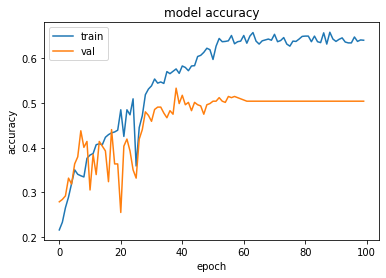

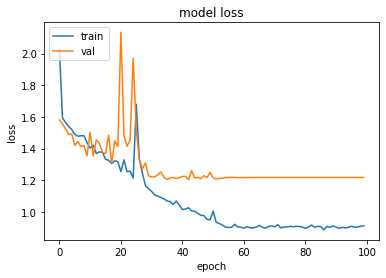

In [11]:
# Plot training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Validate

In [12]:
def test_model(model):
    preds = model.predict(X_test)
    return preds

# Unify slices into songs
def unify_slices(y_pred_aux, y_true_aux, threshold):
    y_pred = []
    y_true = []
    
    labels = movements + ['undefined']
    cont = 0
    for i in Z_test:
        counter = Counter(y_pred_aux[cont : cont+i[0]])

        # Si es mayor a un porcentaje de los casos, lo ponemos como etiqueta
        if (counter.most_common()[0][1] > threshold * i[0]):
            y_pred.append(counter.most_common()[0][0])
        else:
            y_pred.append(num_classes + 1)

        y_true.append(i[1])
        cont += i[0]
    
    return y_pred, y_true, labels

In [13]:
# Test data

print('Loading Test Data...')
X_test, Y_test, Z_test = load_data(validate_route, test_samples, mode='test')

Loading Test Data...



239
239


In [14]:
# Testing block

model = load_model(os.path.join(model_route, 'gilgamesh.h5'))
preds = test_model(model)

In [15]:
# Formatting arrays

threshold = 0.4

y_true = []
y_pred = []
y_true_aux = [np.argmax(Y_test[i]) for i in range(len(Y_test))] 
y_pred_aux = [np.argmax(preds[i]) for i in range(len(preds))]

y_pred, y_true, labels = unify_slices(y_pred_aux, y_true_aux, threshold)

del(y_true_aux)
del(y_pred_aux)

In [16]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

Accuracy: 0.5188284518828452
F1 Score: [0.53703704 0.33333333 0.54166667 0.73684211 0.41584158]


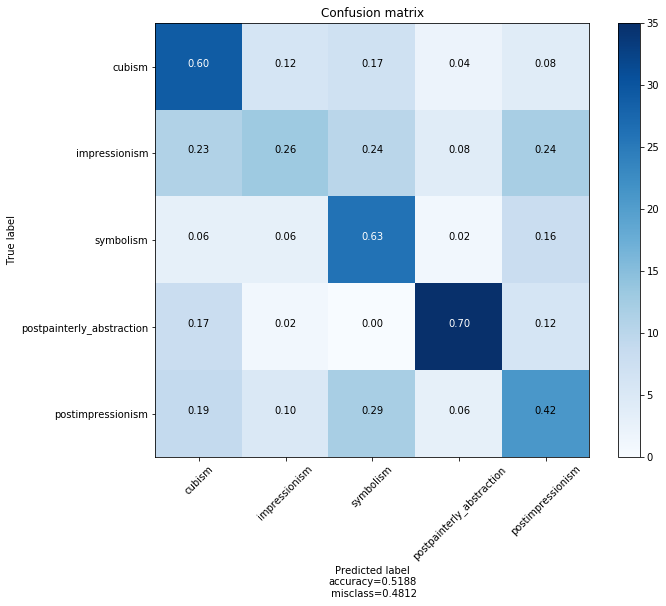

In [17]:
# Print results

print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
print('F1 Score: ' + str(f1_score(y_true, y_pred, average=None)))


# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_matrix, normalize=True, target_names=movements)